In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio import plot

def plot_map(data, transform):
    """Plots single band of Sentinel-2 image and adds the wildfire position as a point."""
    fig, ax = plt.subplots(figsize=(10, 10))
    nbr_map = plot.show(data, transform=transform, interpolation="none", cmap=plt.cm.inferno, ax=ax, vmin=-0.1, vmax=1.0)
    
    # Set the coordinates of the Volcano in UTM33N
    easting, northing = 728443.94, 1601283.24
    
    # Set a distance to reduce the map extent to the surrounding 10 kilometres
    distance = 10000
    
    # Set the the x and y scales (Extent of the map)
    ax.set_xlim(easting - distance, easting + distance)
    ax.set_ylim(northing - distance, northing + distance)
    
    # Plot the position of the forest as red dot
    ax.scatter(easting, northing, s=10, c="r")
    
    plt.colorbar(nbr_map.get_images()[0])
    plt.show()

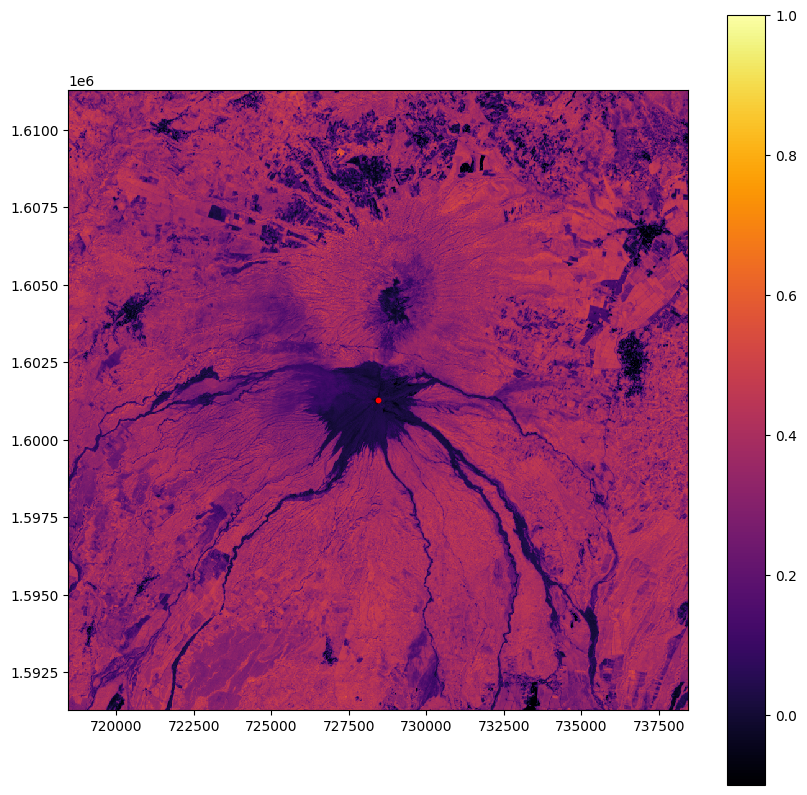

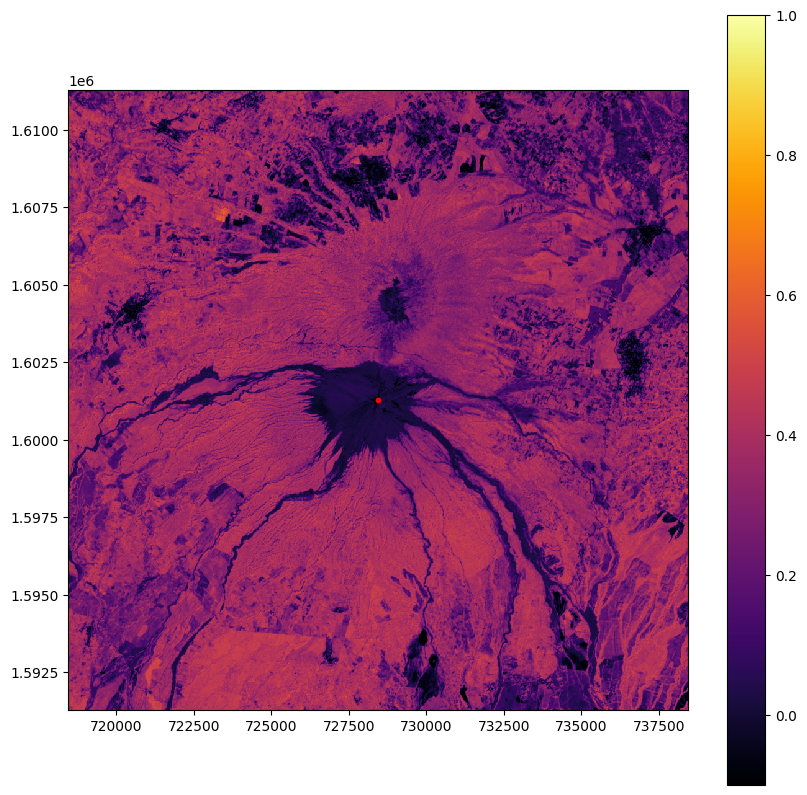

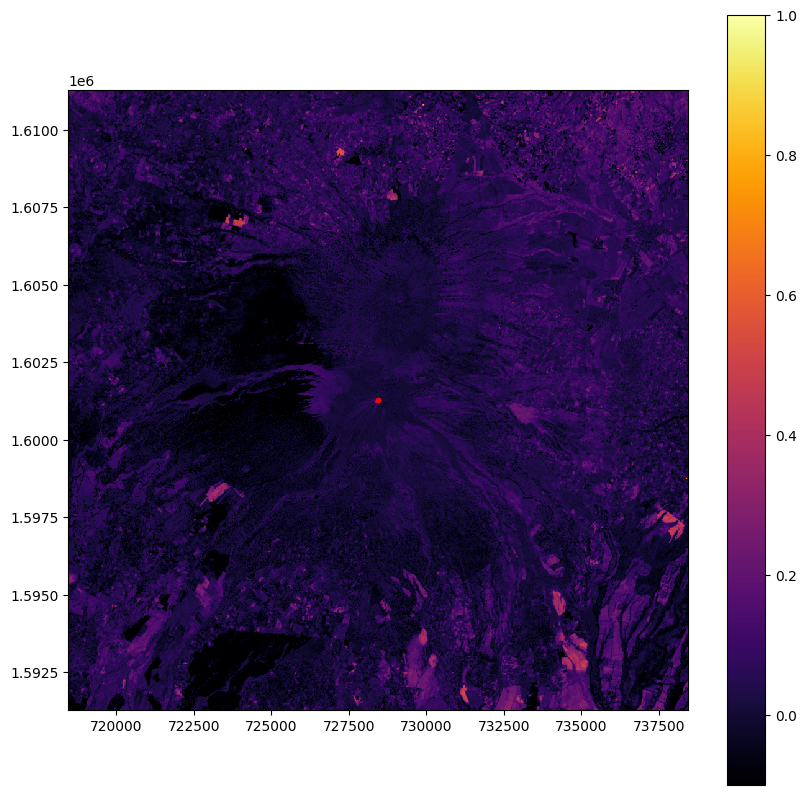

In [5]:
def nbr(nir, swir):
    """Calculates the Normalized Burn Ratio."""
    return (nir - swir) / (nir + swir + 1e-10)  # Adding a small number to avoid division by zero

raster_pre = rasterio.open("L2A_T15PYS_A044367_20231220T163818.tiff")
raster_post = rasterio.open("L2A_T15PYS_A045082_20240208T163125.tiff")


nbr_pre = nbr(raster_pre.read(4), raster_pre.read(5))
nbr_post = nbr(raster_post.read(4), raster_post.read(5))


dnbr = nbr_pre - nbr_post


transform = raster_pre.transform
plot_map(nbr_pre, transform)
transform1 = raster_post.transform
plot_map(nbr_post, transform1)

# Plot the dNBR as a map
plot_map(dnbr, transform1)

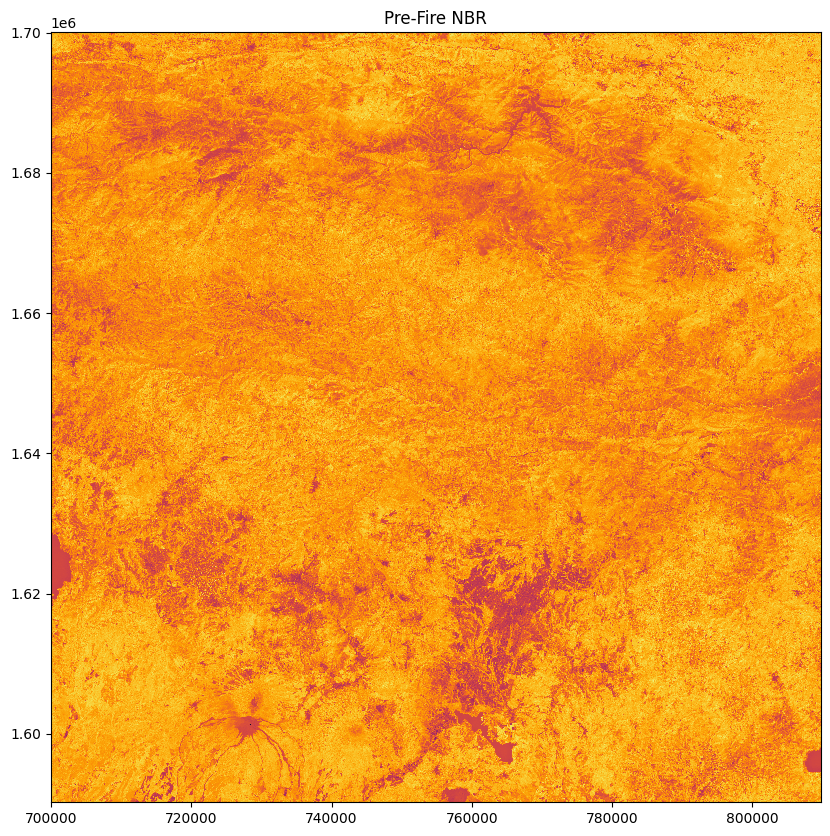

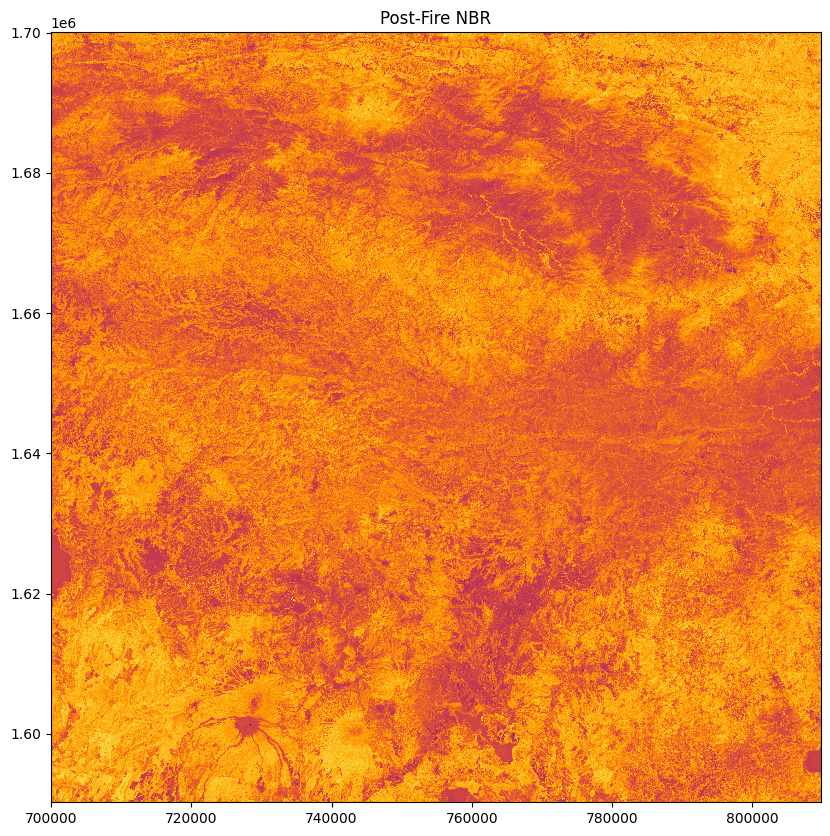

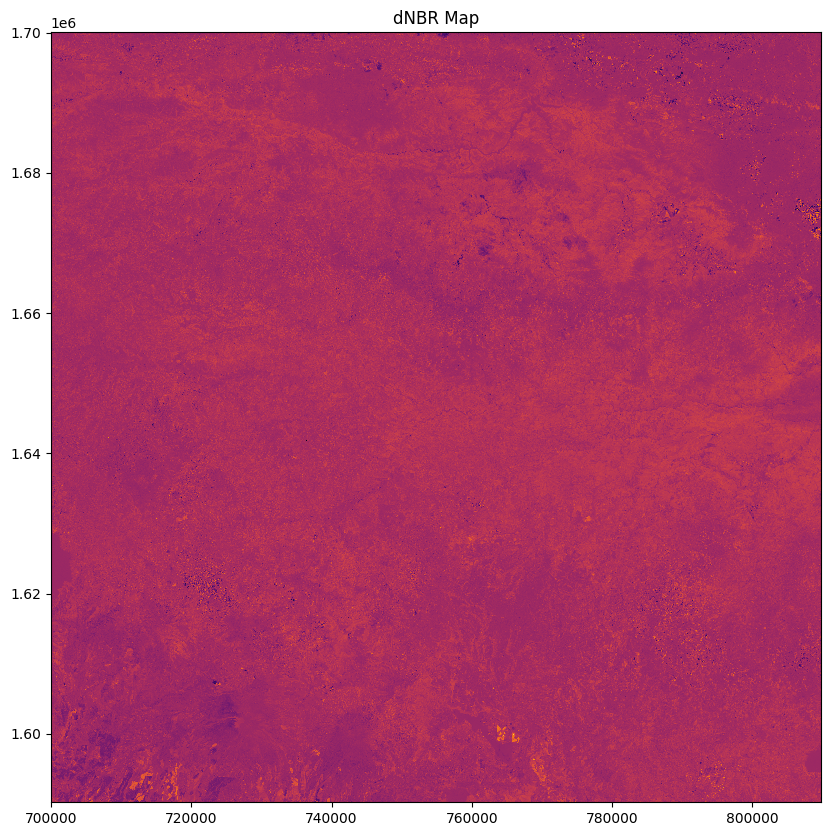

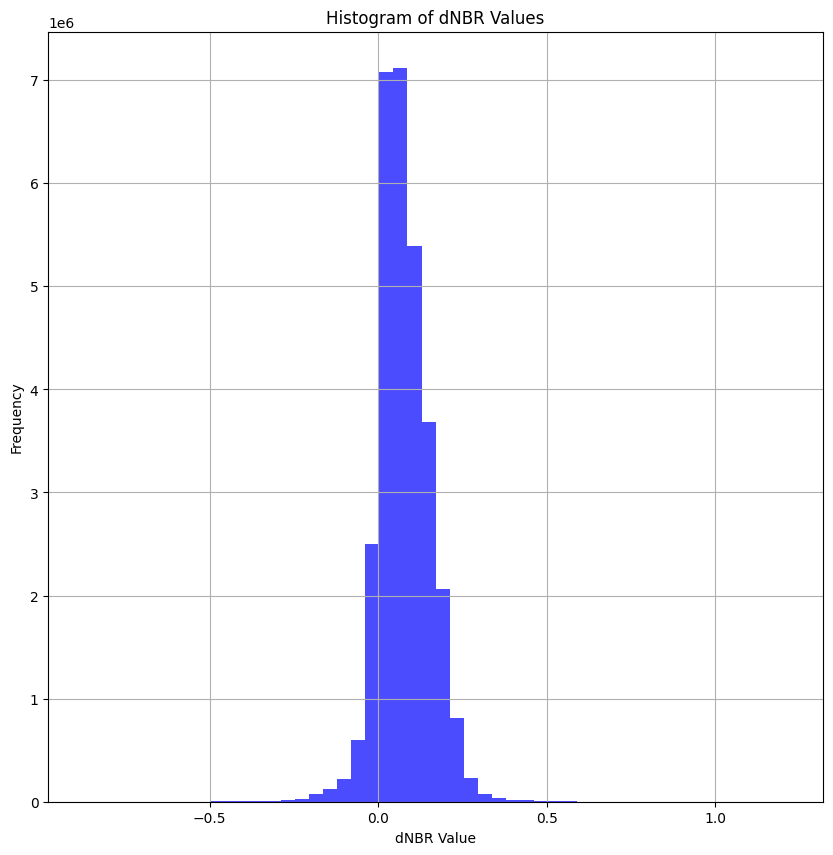

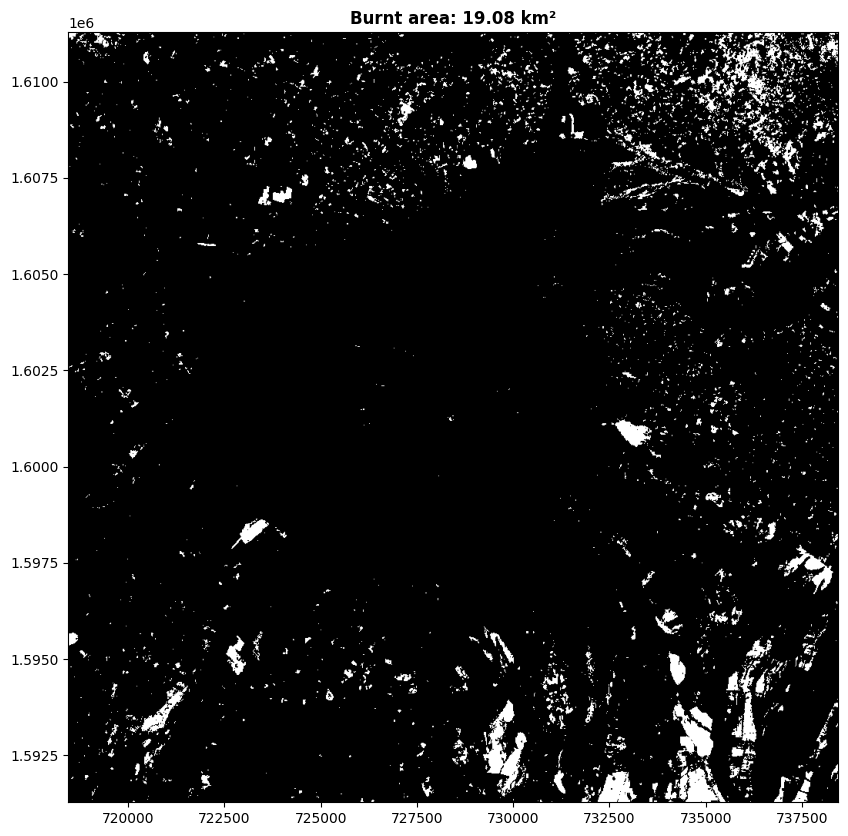

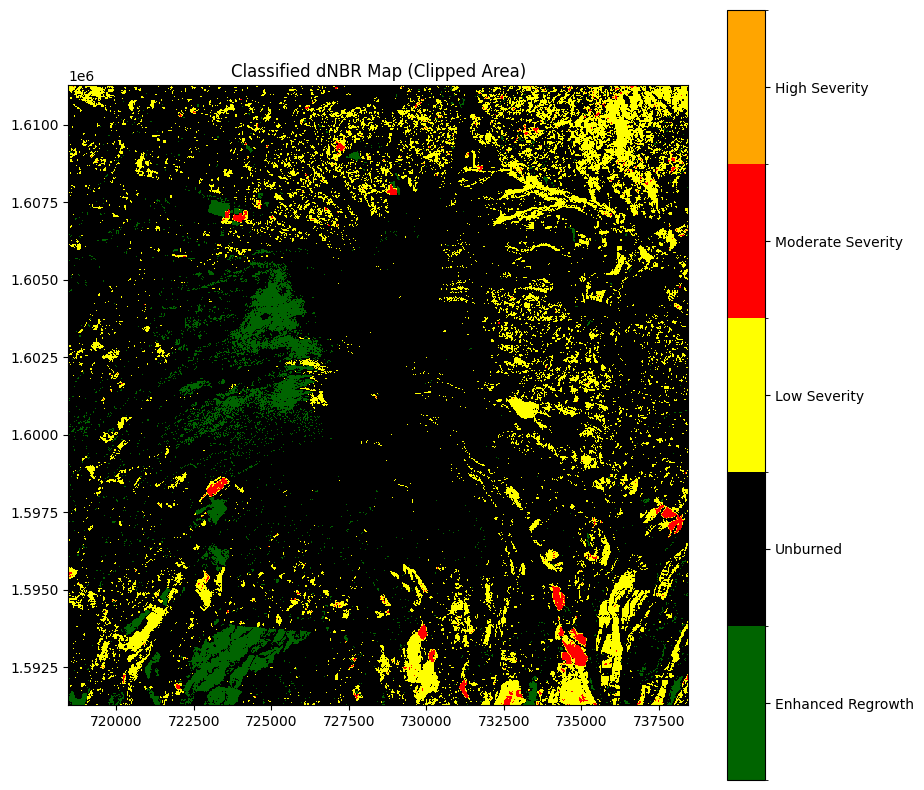

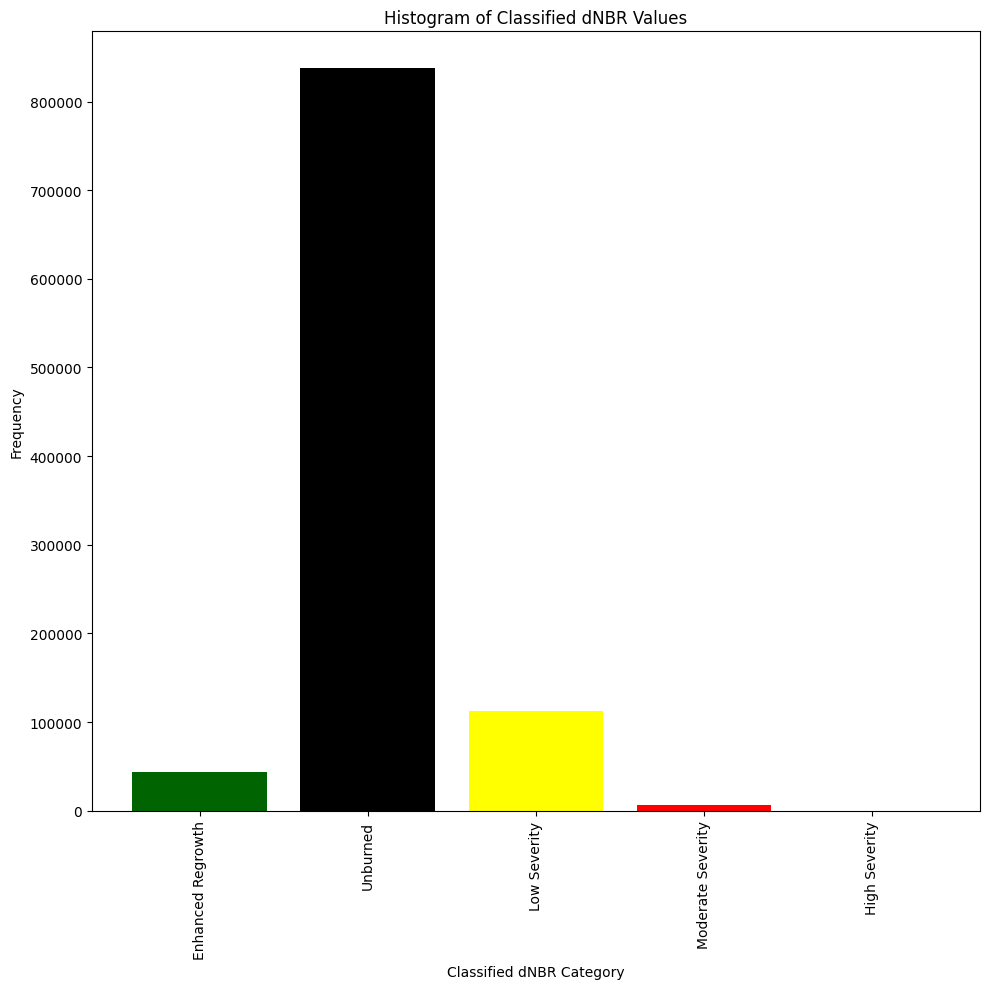

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show

def nbr(nir, swir):
    """Calculates the Normalized Burn Ratio."""
    return (nir - swir) / (nir + swir + 1e-10)  # Adding a small number to avoid division by zero

def plot_map(band_data, transform, title):
    """Function to plot the map of the given band data."""
    fig, ax = plt.subplots(figsize=(10, 10))
    easting, northing = 728443.94, 1601283.24
    distance = 10000 # Set a distance to reduce the map extent to the surrounding 10 kilometres
    
    # Set the the x and y scales (Extent of the map)
    ax.set_xlim(easting - distance, easting + distance)
    ax.set_ylim(northing - distance, northing + distance)
    show(band_data, transform=transform, ax=ax, cmap='viridis', title=title)
    plt.colorbar
    
    plt.show()

raster_pre = rasterio.open("L2A_T15PYS_A044367_20231220T163818.tiff")
raster_post = rasterio.open("L2A_T15PYS_A045082_20240208T163125.tiff")

nbr_pre = nbr(raster_pre.read(4), raster_pre.read(5))
nbr_post = nbr(raster_post.read(4), raster_post.read(5))
dnbr = nbr_pre - nbr_post

    
easting, northing = 728443.94, 1601283.24
distance = 10000 # Set a distance to reduce the map extent to the surrounding 10 kilometres   


# Plot the maps for the entire area

# Pre-Fire NBR
fig, ax = plt.subplots(figsize=(10, 10))


show(nbr_pre, transform=raster_pre.transform, ax=ax, cmap='inferno', interpolation='none')
ax.set_title("Pre-Fire NBR")
plt.colorbar
plt.show()

# Post-Fire NBR
fig, ax = plt.subplots(figsize=(10, 10))

show(nbr_post, transform=raster_post.transform, ax=ax, cmap='inferno', interpolation='none')
ax.set_title("Post-Fire NBR")
plt.colorbar
plt.show()

#dNBR
fig, ax = plt.subplots(figsize=(10, 10))

show(dnbr, transform=raster_post.transform, ax=ax, cmap='inferno', interpolation='none')
ax.set_title("dNBR Map")
plt.colorbar
plt.show()

#plot_map(nbr_pre, raster_pre.transform, "Pre-Fire NBR")
#plot_map(nbr_post, raster_post.transform, "Post-Fire NBR")
#plot_map(dnbr, raster_post.transform, "dNBR Map")

# Histogram of dNBR values
plt.figure(figsize=(10, 10))
plt.hist(dnbr.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of dNBR Values")
plt.xlabel("dNBR Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Clipped analysis for a specific area
easting, northing = 728443.94, 1601283.24  # Example coordinates for analysis
distance_burnt = 10000  # meters
left, right = easting - distance_burnt, easting + distance_burnt
bottom, top = northing - distance_burnt, northing + distance_burnt
window = raster_pre.window(left, bottom, right, top)
window_transform = raster_pre.window_transform(window)

# Calculate NBR for pre and post fire images within the specified window
nbr_pre_clipped = nbr(raster_pre.read(4, window=window), raster_pre.read(5, window=window))
nbr_post_clipped = nbr(raster_post.read(4, window=window), raster_post.read(5, window=window))
dnbr_clipped = nbr_pre_clipped - nbr_post_clipped

# Threshold for identifying burnt areas
threshold = 0.15
burnt = (dnbr_clipped > threshold).astype(int)
area_burnt_km2 = burnt.sum() * (20 * 20) / 1e6  # Sentinel-2's pixel size is 20m x 20m

# Visualize the burnt areas
fig, ax = plt.subplots(figsize=(10, 10))
show(burnt, transform=window_transform, ax=ax, cmap='binary_r', title=f"Burnt area: {area_burnt_km2:.2f} km²")
plt.show()

# Classification of dNBR values into burn severity categories for the clipped area
thresholds = {
    'Enhanced Regrowth': (-np.inf, -0.1),
    'Unburned': (-0.1, 0.1),
    'Low Severity': (0.1, 0.27),
    'Moderate Severity': (0.27, 0.66),
    'High Severity': (0.66, np.inf)
}



dnbr_classified = np.zeros_like(dnbr_clipped, dtype=np.float32)
for i, (category, (min_val, max_val)) in enumerate(thresholds.items(), 1):
    dnbr_classified[(dnbr_clipped >= min_val) & (dnbr_clipped < max_val)] = i

# Create a colormap for the classification
cmap = plt.matplotlib.colors.ListedColormap(['darkgreen', 'black', 'yellow', 'red', 'orange'])
bounds = [ 1, 2, 3, 4, 5,6]
norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Visualization of the classified dNBR map with corrected legend and colorbar
fig, ax = plt.subplots(figsize=(10, 10))
show(dnbr_classified, transform=raster_pre.window_transform(window), cmap=cmap, norm=norm, interpolation='none', ax=ax)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, boundaries=bounds, ticks=[(b + 0.5) for b in bounds[:-1]], spacing='proportional')
cbar.set_ticklabels(list(thresholds.keys()))
ax.set_title("Classified dNBR Map (Clipped Area)")
plt.show()


# Histogram for classified dNBR data
fig, ax = plt.subplots(figsize=(10, 10))
unique, counts = np.unique(dnbr_classified, return_counts=True)
plt.bar(unique, counts, color=['darkgreen', 'black', 'yellow', 'red', 'orange'])
plt.title('Histogram of Classified dNBR Values')
plt.xlabel('Classified dNBR Category')
plt.ylabel('Frequency')
plt.xticks(ticks=unique, labels=list(thresholds.keys()), rotation='vertical')
#plt.grid(True)
plt.tight_layout()
plt.show()
